# Cluster Analysis

In this tutorial we demonstrate how to use RSMLM for cluster analysis of single molecule localization microscopy (SMLM) data. We cover persistence based clustering (ToMATo) as well as DBSCAN, Ripley K based clustering and Voronoi segmentation. All sections will require the RSMLM package so lets start by loading it:

In [43]:
library(RSMLM)

Now lets load a simple example to work with (this was generated using the "Data simulation tutorial").

In [44]:
# load the csv file
detectionList <- read.csv('../data/detectionListSimpleClusters.csv')

numDetections <- dim(detectionList)[1]
print(paste('There are', numDetections, 'detections in this dataset'))


[1] "There are 759 detections in this dataset"


detectionList is a data frame containing detection coordinates ('x' and 'y'), and also ground truth molecule and cluster indices for each detection ('moleculeIndex' and 'clusterIndex').

[1] "There are 4 clusters in the dataset"


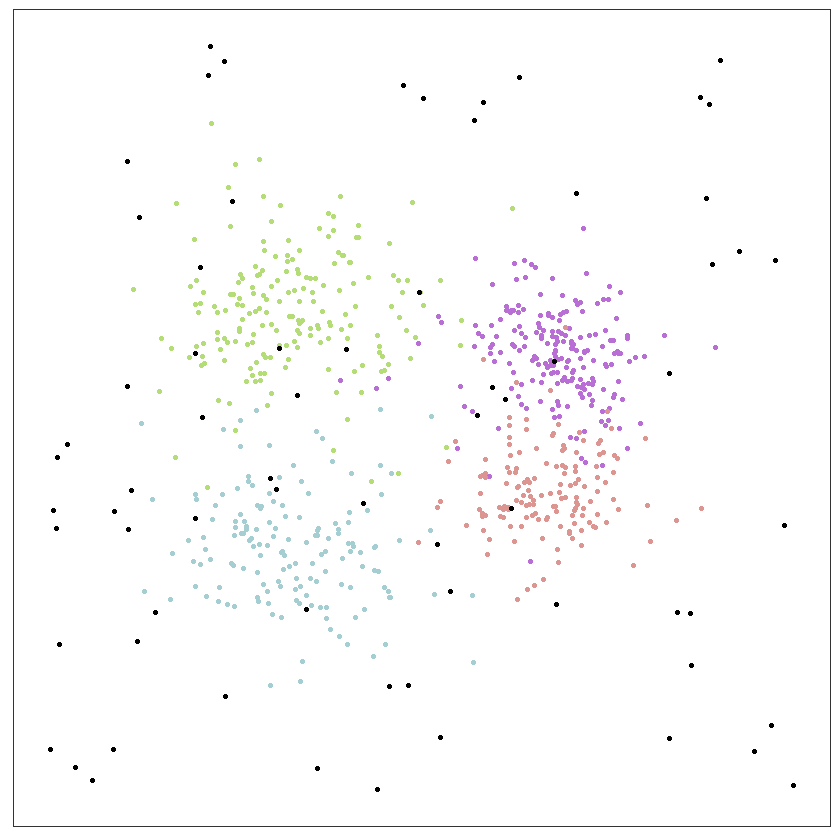

In [45]:
# get the ground truth value for the number of clusters.
# count all unique cluster indices (excluding 0, which is noise)
numClustersGT <- sum(unique(detectionList$clusterIndex) > 0)

print(paste('There are', numClustersGT, 'clusters in the dataset'))

# create a matrix containing the detection coordinates
coords <- as.matrix(detectionList[, c('x', 'y')])

# plot the detection coordinates coloured by cluster index (ground truth)
plotClusterScatter(coords, detectionList$clusterIndex)


## ToMATo clustering

Here we use persistence based clustering (ToMATo) to segment the data. ToMATo is capable of segmenting clusters which are close together and vary in density. We must specify a search radius for estimation of the density estimate, and also a persistence threshold which is used to determine if clusters should be merged.


[1] "ToMATO found 4 clusters in the dataset. The ground truth number is 4"


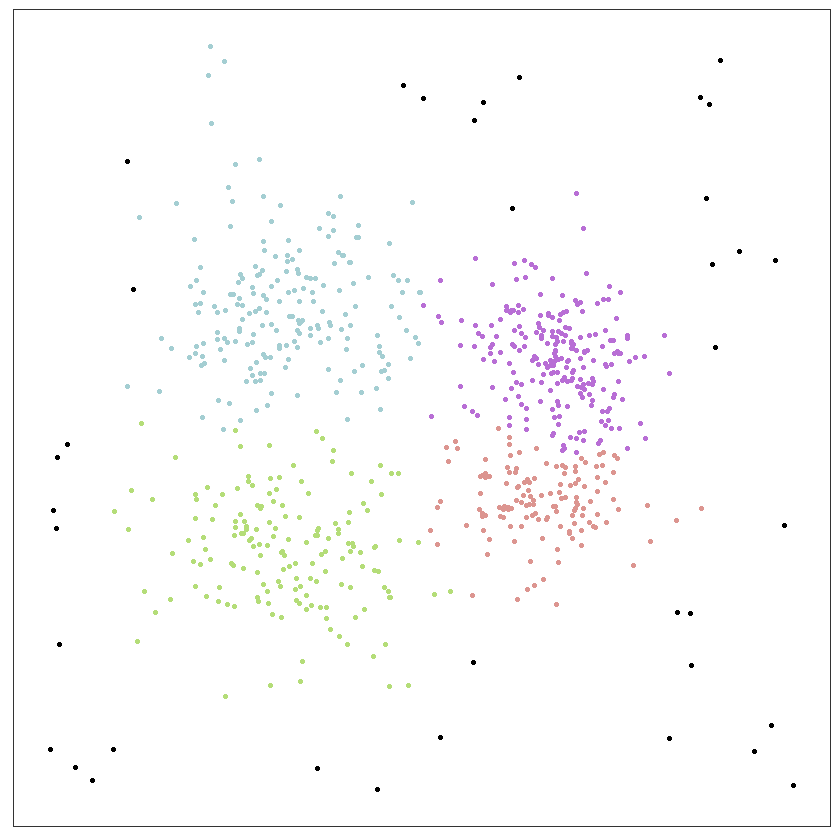

In [46]:
# search radius
tomatoR <- 19
# persistence threshold
tomatoThresh <- 6

# cluster data using ToMATo
clusterIndexTom <- clusterTomato(coords, tomatoR, tomatoThresh)

# number of clusters
numClustersTom <- sum(unique(clusterIndexTom) > 0)

print(paste('ToMATo found', numClustersTom, 'clusters in the dataset. The ground truth number is', numClustersGT))

# plot the ToMATo clustering result
plotClusterScatter(coords, clusterIndexTom)




We can also generate ToMATo diagrams. The birth and death densities for each cluster are plotted alongside a potential persistence threshold. This is useful to help guide parameter selection.

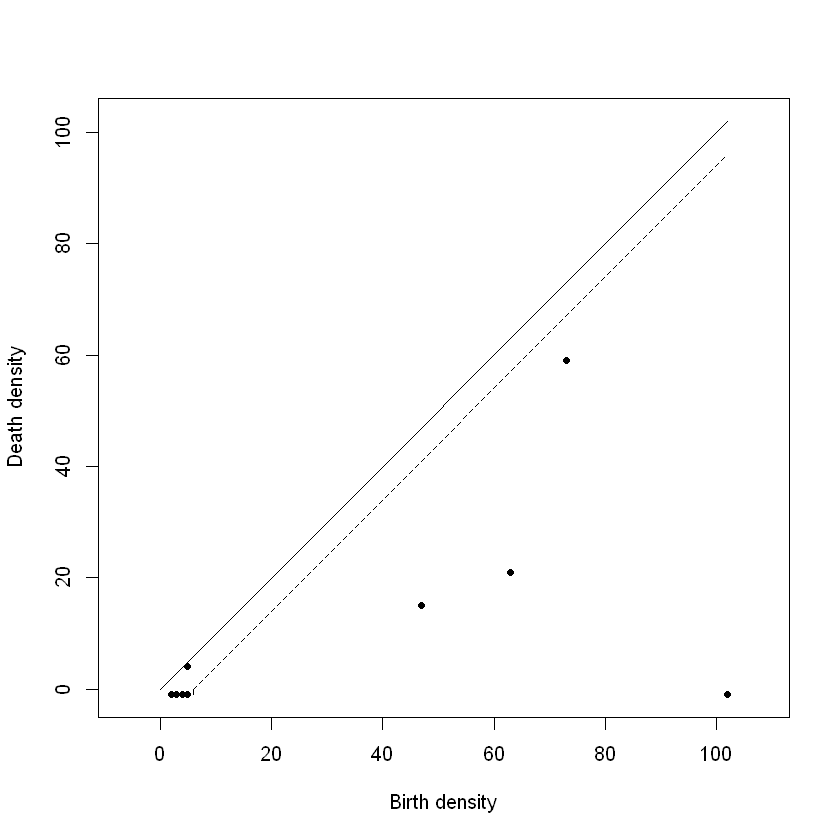

In [47]:
# create the ToMATo diagram
# This is just a 2 column matrix containing the birth and death densities of all modes
tomatoDiag <- tomatoDiagram(coords, tomatoR)

# simple plotting function
plotTomatoDiagram(tomatoDiag, tomatoThresh)

## Filtering clusters and calculating cluster statistics

Clusters can be filtered either by number of detections, or by area (volume in 3D). Cluster area is defined by the convex hull of the cluster detections. Here we choose to remove the dense clusters, which have a smaller cluster area. Detections in clusters outside the specified range are assigned a cluster index of zero.

[1] "After filtering there are 2 clusters remaining."


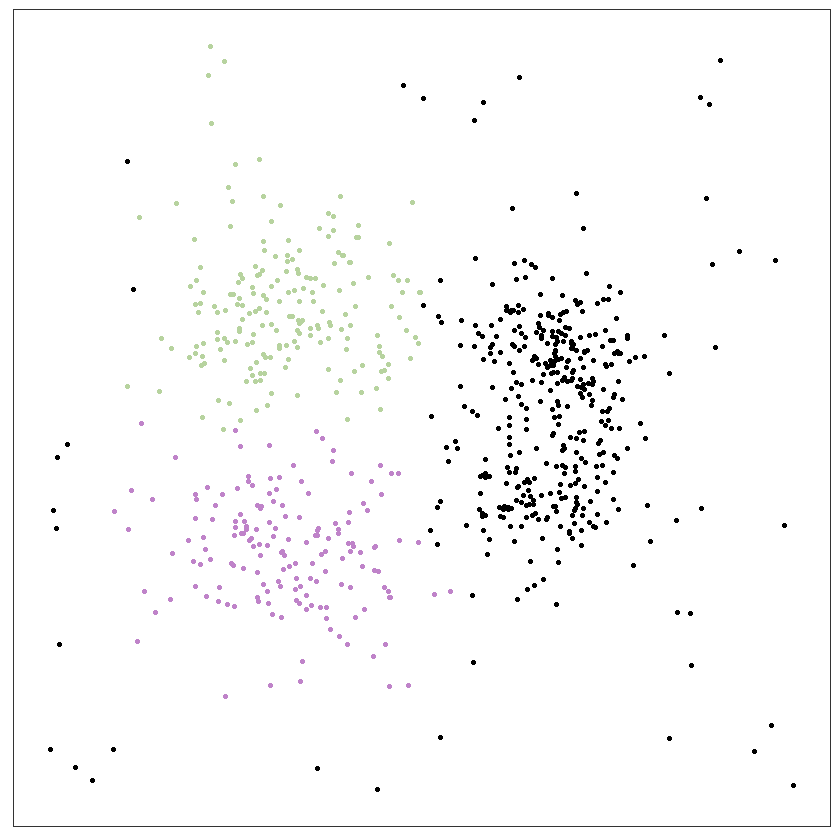

In [48]:
# minimum and maximum number of detections for cluster filtering
minDetectionsPerCluster <- 10;
maxDetectionsPerCluster <- 500;
# minimum and maximum cluster area
minClusterArea <- pi *  50 ^ 2
maxClusterArea <- pi *  100 ^ 2

# filter clusters by number of detections
clusterIndicesFilt <- filtClustDetections(clusterIndexTom, minDetectionsPerCluster, maxDetectionsPerCluster) 

# filter clusters by area
clusterIndicesFilt <- filtClustArea(coords, clusterIndicesFilt, minClusterArea, maxClusterArea)

numFilteredClusters <- sum(unique(clusterIndicesFilt) > 0)

print(paste('After filtering there are', numFilteredClusters, 'clusters remaining.'))

# plot the filtered clusters
plotClusterScatter(coords, clusterIndicesFilt)                                   


We can also calculate per cluster statistics using the clusterStats() function. This number of detections, area, volume density and center of mass for each cluster are calculated.

In [53]:
# calculate per cluster statistics
# this a data frame with one row per cluster
clusterStatistics <- clusterStats(coords, clusterIndexTom)

# print the number of detections in each cluster
print(paste('Number of detections in cluster', 1 : numClustersTom, ':', clusterStatistics$numDetectionsCluster))

# calculate mean statistics across all clusters
meanClusterStats <- colMeans(clusterStatistics)

print(paste('Mean cluster area =', meanClusterStats['areasCluster']))
print(paste('Mean cluster density =', meanClusterStats['densitiesCluster']))

[1] "Number of detections in cluster 1 : 197"
[2] "Number of detections in cluster 2 : 164"
[3] "Number of detections in cluster 3 : 136"
[4] "Number of detections in cluster 4 : 225"
[1] "Mean cluster area = 8868.2422986293"
[1] "Mean cluster density = 0.0227129278133447"


## Other clustering algorithms

RSMLM can also be used to perform DBSCAN, Ripley K based clustering and Voronoi segmentation.  

### DBSCAN

To run DBSCAN we specify a search radius which is used to calculate the number of neighbouring detections. We must also specify a threshold for the minimum number of neighbours required for a detection to be considered a 'core' point.


[1] "DBSCAN found 3 clusters in the dataset. The ground truth number is 4"


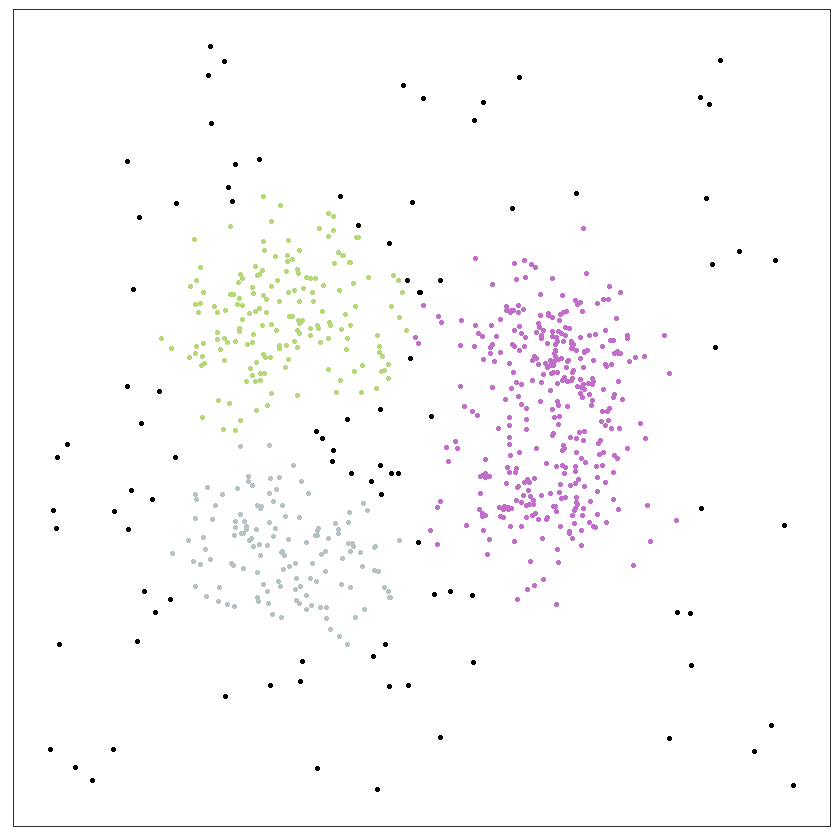

In [50]:
# search radius
dbscanR <- 25
# threshold for number of neighbours
dbscanThresh <- 50

# perform dbscan 
clusterIndexDbscan <- clusterDBSCAN(coords, dbscanR, dbscanThresh)

numClustersDbscan <- sum(unique(clusterIndexDbscan) > 0)

print(paste('DBSCAN found', numClustersDbscan, 'clusters in the dataset. The ground truth number is', numClustersGT))

# plot the DBSCAN clustering result
plotClusterScatter(coords, clusterIndexDbscan)



### Ripley's K based clustering

Ripley K based clustering has three parameters to set: a search radius, a threshold density and the area (or volume) of the field of view. The search radius, r, is used to calculate the Ripley K and L functions. Detections with L - r value less than the threshold are filtered. Here the field of view area is 300nm$\times$300nm.

[1] "Ripley K based clustering found 3 clusters in the dataset. The ground truth number is 4"


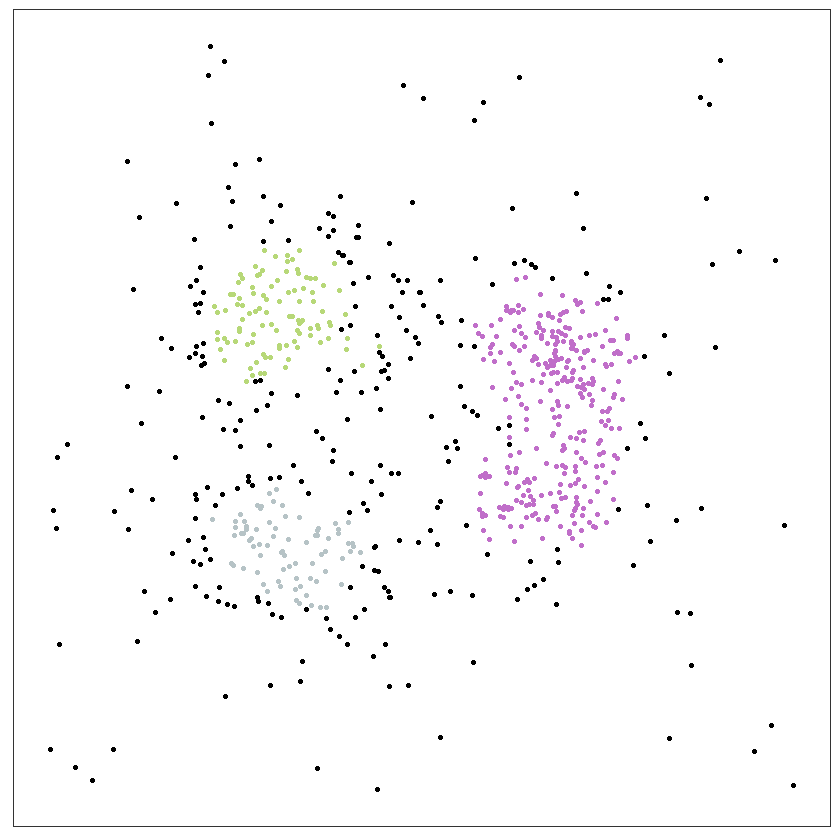

In [51]:
# search radius
ripleyR = 15
# threshold for L - r
ripleyThresh = 10
# area for field of view (this shouldnt be changed)
roiArea = 300 * 300

# cluster detections using Ripley K based method
clusterIndexRipley <- clusterRipley(coords, ripleyR, ripleyThresh, roiArea)

numClustersRipley <- sum(unique(clusterIndexRipley) > 0)

print(paste('Ripley K based clustering found', numClustersRipley, 
            'clusters in the dataset. The ground truth number is', numClustersGT))

# plot the Ripley K based clustering result
plotClusterScatter(coords, clusterIndexRipley)

### Voronoi based segmentation

For Voronoi tesseltation based segmentation we need to specify the density factor. This is a threshold for normalised detection density where the density for each detection has been divided by the mean value across the full field of view.

Detection density can be defined as either the inverse of tile area (densityChoice = 0), or mean first rank tile area (densityChoice = 1). 

[1] "Voronoi segmentation found 3 clusters in the dataset. The ground truth number is 4"


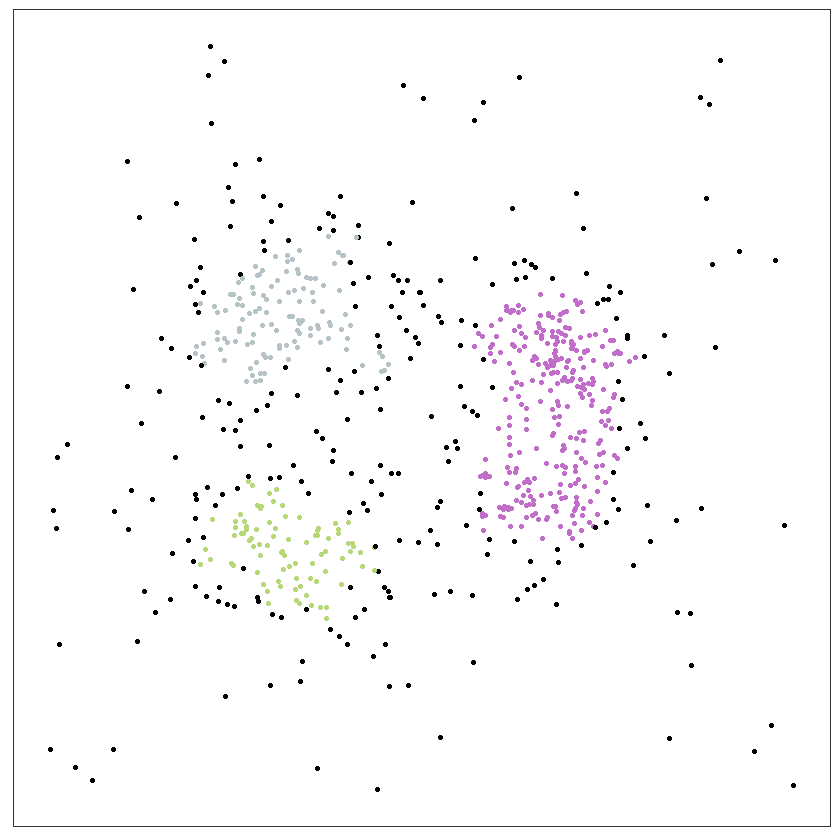

In [54]:
# density factor
voronoiDensityFac <- 2
# choice of method to calculate density estimate
densityChoice <- 0
# area for field of view (this shouldnt be changed)
roiArea = 300 * 300

# estimate the mean detection density by dividing the total number of detections by the field of view area
numDetections <- dim(detectionList)[1]
averageDensity <- numDetections / roiArea

# cluster using Voronoi based segmentation
clusterIndexVoronoi <- clusterVoronoi(coords, voronoiDensityFac * averageDensity, densityChoice) 


# filter clusters by number of detections to remove clusters with 1 or 2 detections
clusterIndexVoronoi <- filtClustDetections(clusterIndexVoronoi, 3, 1e20) 

numClustersVoronoi<- sum(unique(clusterIndexVoronoi) > 0)

print(paste('Voronoi segmentation found', numClustersVoronoi, 
            'clusters in the dataset. The ground truth number is', numClustersGT))

# plot the Voronoi segmentation result
plotClusterScatter(coords, clusterIndexVoronoi)